In [1]:
#Bowerbird null model (all males are guarders)

#Key
#Notes- Paramters contain underscores, while functions don't
#SB: Stay at bower
#FG: Foraging
#MT: Maraud travel (travel to rival's bower)
#MA: Maraud action (destroy bower if absent, have antagonistic interaction in present)
#MR: Maraud return (return to own bower)
#RB: Repair own bower
#MT_vs_FG: the probability of next transition away from SB being to MT (otherwise it would be to FG)
#a=-1: denotes a staying at bower action on ticket
#a=-2: denotes a foraging action on ticket
#a=-3: denotes a female visiting action on a ticket
#a=-4: denotes travel to another male's bower
#a=-5: denotes marauding of another male's bower
#a=-6: denotes returning from another male's bower
#a=-7: denotes a bower repair action on a ticket
#target: the male/node an action is preformed on. For maurading, the target is the bird under potential attack. For mating, target is male being mated with. For other activities other then maurading and mating, owner and target are the same.
#owner: The male or female actively performing an action. For mating, the female is the owner. For all other activities, the owner is male.
#networkwriter: generates network where everybird is connected
#addtotimeline: adds tickets to timeline
#travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
#if the relationship between distance and travel preference is linear
#improb: The probability of traveling improb_distance or less
#improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel
#lamb: lambda calculated by solving improb=1-numpy.exp(-lamb*improb_distance)
#bower_states: options are 1(bower intact) and 0 (bower destroyed-will never be the case when all guarders)
#male_states: options are [leave_time, leave_action] (male present at bower) and 0 (male absent from bower)
#fitness_states: keeps track of number of matings a given male has had
#t: time
#nodes: total number of male bowerbirds in the network
#node_dist: the node by nde matrix with distances between each node
#node_graph: matrix with individuals 1 through nodes numbered by going through each row
#tau: Length of time an activity takes. If a foraging ticket has a tau of 0.5 and occurs at t=1, then the bird is foraging for 30 minutes, at which point a SB activity will start (at t=1.5).
#t_court: the amount of time it takes a female to court+mate with a male, generated from a normal distribution


import math
import random
import numpy as numpy
import matplotlib.pyplot as plt


#Parameters:
t=0.0 #start at time 0
t_max=2#*4*30 #2 months in hrs (assume no nights so 12 hr = 1 day)
timeholder=0
timeline=[] #initialize the timeline
discards=[] #where we put the old version of tickets that get over-written/moved
#We've moved away from using these params with expovariate (how we handle FV is still TBD)
#So THE BELOW 3 SHOULD BE COMMENTED OUT (but rn we don't want the handler funcs to yell at us)
FV_param=[1, t_max/2] #5days, tmax/3 #0.2 #nodes/0.19 #totally random
FG_param=3 #larger values lead to foraging ending earlier, because taus are smaller
SB_param=1.5 #larger values lead to bowerstay ending earlier, because taus are smaller
RB_param=2 #made up -- takes 30mins (every time -- no distribution) to repair bower
MA_param=.1 #made up -- takes 6mins (every time -- no distribution) to maraud bower
MT_vs_FG=.05 #compared 20 feedings/day to .1 maraudings/hr
nodes=100
bower_states=[1]*nodes
male_states=[[0]*2]*nodes #start at foraging now
fitness_states=[0]*nodes
success_rates=1
success_times=[] #going to change this to be a vector of times when the female leaves (at this point, sucessful mating has occured)
recents_list=[]
max_visits=6 #STEEEEVEEEE
bird_speed=12*3600 #m/hr (12m/s)
d=150.0




# makes a ticket
def ticketgenerator(tau,t, o, a, targ):
    ticket={
        'tau': tau,
        'time': t,
        'owner': o,
        'action': a,
        'target': targ
    }
    return ticket;

#writes the edges to a network of n birds where everyone is connected to everyone else 
def networkwriter(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network


# function for determining the next time based on our rate parameters
def nexttau(action):
    x=-1
    while x<=0:
        switcher = {
            -1: numpy.random.normal(loc=.1583, scale=.09755, size=1)[0], #choose when to leave bower (generate a tau for bower stay)
            -2: numpy.random.gamma(shape=1.5, scale=5, size=1)[0]/60, #choose when to stop foraging (generate a tau for foraging)
            -3: numpy.random.uniform(FV_param[0], FV_param[1]), #FV_param... totally arbitrary so we should think about it
            -5: MA_param, #in the future we'll do something with it
            -7: RB_param #in the future we'll do something with it 
        }
        x=switcher.get(action)
    return x
    

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def addtotimeline(tic, timeline):
    if not timeline:
        timeline.append(tic)
    else:
        ind=len(timeline)-1
        end=0
        while (tic['time']<timeline[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
            ind=ind-1 
            if(ind<0):
                end=1
        ind=ind+1
        timeline.insert(ind, tic)
        
#Stay at bower ticket handler. Ticket is read, and male state changes to at bower. Can generate repair bower, foraging, or maurad travel ticket.
def SBtickethandler(SB_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times):
    ow=SB_tic['owner'] 
    if male_states[ow]!=0.0: #because any male who is at his bower was last repairing his bower (not coming from FG or MR) 
        bower_states[ow]=1
    t=SB_tic['time']
    ta=SB_tic['tau']
    if bower_states[ow]==0: #if male returns to a destroyed bower, must repair it
        RB_tau=nexttau(-7)
        SB_tic['tau']=0
        future_t=RB_tau+t
        if future_t>t_max:
            RB_tau=RB_tau-(future_t-t_max)   
        tic=ticketgenerator(RB_tau,t,ow,-7,ow) #immediately, RB_tic starts
        addtotimeline(tic,timeline)
        male_states[ow]=[tic['time'], tic['action']]
    else:
        MT_FG_time=ta+t
        if MT_FG_time<t_max:
            decider=random.random()
            if decider<MT_vs_FG: #if transition to MT
                targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[ow]) #choosing the male to maurad based on visit preferences
                MT_tau=travel_times[ow][targ]
                future_t=MT_tau+MT_FG_time
                if future_t>t_max:
                    MT_tau=MT_tau-(future_t-t_max)                    
                tic=ticketgenerator(MT_tau,MT_FG_time,ow,-4, targ)
            else:
                FG_tau=nexttau(-2)
                future_t=FG_tau+MT_FG_time
                if future_t>t_max:
                    FG_tau=FG_tau-(future_t-t_max)   
                tic=ticketgenerator(FG_tau,MT_FG_time,ow,-2, ow) #-2 denotes foraging action
            addtotimeline(tic,timeline)
            male_states[ow]=[tic['time'], tic['action']]
            
            
#Foraging ticket handler. Ticket read, and male state changes to no longer at bower. Generates a stay at bower ticket.
def FGtickethandler(FG_tic, timeline, t_max, male_states, timeholder):
    ow=FG_tic['owner'] 
    t=FG_tic['time']
    ta=FG_tic['tau']
    print(male_states[ow])
    if male_states[ow][0]!=t:
        discards.append(FG_tic)
        timeline.pop(timeholder)
        timeholder-=1
    else:
        male_states[ow]=0 #male is no longer at bower
        SB_time=t+ta
        SB_tau=nexttau(-2)
        if SB_time<t_max:
            future_t=SB_tau+SB_time
            if future_t>t_max:
                SB_tau=SB_tau-(future_t-t_max)               
            SB_tic=ticketgenerator(SB_tau,SB_time,ow,-1, ow) #-1 denotes staying at bower
            addtotimeline(SB_tic,timeline)
        
#Maurad travel ticket handler. Male state changes to no longer at bower, and generates a maurad action ticket.
def MTtickethandler(MT_tic,timeline,t_max,male_states, timeholder):
    ow=MT_tic['owner']
    targ=MT_tic['target']
    t=MT_tic['time']
    ta=MT_tic['tau']
    if male_states[ow][0]!=t:
        discards.append(MT_tic)
        timeline.pop(timeholder)
        timeholder-=1
    else:
        male_states[ow]=0 #male is no longer at his bower
        MA_time=t+ta
        if MA_time<t_max:
            MA_tau=nexttau(-5)
            future_t=MA_tau+MA_time
            if future_t>t_max:
                MA_tau=MA_tau-(future_t-t_max)   
            MA_tic=ticketgenerator(MA_tau,MA_time, ow, -5, targ) #generate a maurading action ticket
            addtotimeline(MA_tic, timeline)
            
def MAtickethandler(MA_tic, timeline, t_max, male_states, bower_states, travel_times):
    ow=MA_tic['owner'] 
    targ=MA_tic['target']
    if male_states[targ]==0 and bower_states[targ]==1: #if the bower is intact and its owner is absent
        bower_states[targ]=0
    else: #in all other cases bowerbird immediately leaves
        MA_tic['tau']=0 #COMMENT! Changing tau for this ticket as we read it bc stay is cut short by bower owner's presence
    t=MA_tic['time']
    ta=MA_tic['tau']
    MR_time=t+ta
    if MR_time<t_max: 
        MR_tau=travel_times[ow][targ]
        future_t=MR_tau+MR_time
        if future_t>t_max:
            MR_tau=MR_tau-(future_t-t_max)  
        MR_tic=ticketgenerator(MR_tau,MR_time, ow, -6, targ)
        addtotimeline(MR_tic, timeline)

            
def MRtickethandler(MR_tic,timeline,t_max):
    ow=MR_tic['owner']
    targ=MR_tic['target'] #accesing the male the owner chose to maurad based on visit preferences
    t=MR_tic['time']
    ta=MR_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        future_t=SB_tau+SB_time
        if future_t>t_max:
            SB_tau=SB_tau-(future_t-t_max)  
        SB_tic=ticketgenerator(SB_tau,SB_time, ow, -1, ow) #generate stay at bower ticket
        addtotimeline(SB_tic, timeline)
            
def RBtickethandler(RB_tic, timeline, t_max):
    ow=RB_tic['owner']
    t=RB_tic['time']
    ta=RB_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        future_t=SB_tau+SB_time
        if future_t>t_max:
            SB_tau=SB_tau-(future_t-t_max)  
        SB_tic=ticketgenerator(SB_tau, SB_time, ow, -1, ow)
        addtotimeline(SB_tic, timeline)
        

def FVtickethandler(FV_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rate, success_times, recents_list, max_visits):
    targ=FV_tic['target']
    ow=FV_tic['owner']
    t=FV_tic['time']
    recents_list=d["rl{0}".format(ow)]
    r=random.random()
    if bower_states[targ]==1 and male_states[targ]!=0 and r<success_rate: #if the bower is intact and the male is present
        t_court=numpy.random.normal(loc=.1504, scale=.0102, size=1)[0]
        t_court_end=t+t_court
        if male_states[targ][0]<t_court_end:
            if male_states[targ][1]==-4:
                new_targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[targ]) #choosing the male to maurad based on visit preferences
                new_tau=travel_times[new_targ][targ]
            else:
                new_tau=nexttau(male_states[targ][1])
                future_t=new_tau+t_court_end
                if future_t>t_max:
                    new_tau=new_tau-(future_t-t_max)  
                new_targ=targ
            tic=ticketgenerator(new_tau, t_court_end, targ, male_states[targ][1], new_targ) #2 things we don't know rn: tau (would get from SB_time+), target -- in case of MT it's not simply the node -- could gen new tau and target
            addtotimeline(tic, timeline)
            male_states[targ][0]=t_court_end
        recents_list=[]
        fitness_states[targ]=fitness_states[targ]+1 #assumption: female always mates if bower is intact and male present
        success_times.append(t_court_end)
        new_FV_targ=numpy.random.choice(list(range(nodes)))
        decider=random.random() #decide whether female will mate for a second time
        if decider<.8: #half the time she'll mate again due to predation (or for the heck of it -- PJ said 4-5 matings)
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)        
    else: #if female does not successfully mate
        recents_list.append(targ)
        if len(recents_list)==min(max_visits, nodes): 
            recents_list=[]
            print(recents_list)
            new_FV_targ=numpy.random.choice(list(range(nodes)))
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
        else:
            new_FV_targ=-1 #just so that the code goes into the while loop the first iteration
            while(new_FV_targ in recents_list or new_FV_targ==-1):
                new_FV_targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[targ]) #choose a male based on preference (a function of distance)
            new_FV_time=t+travel_times[targ][new_FV_targ] #she goes directly to this male
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
    return recents_list



    
    
    
#FOR LATER
#def MTtickethandler (MT_tic, timeline, )

#distance function
def travel(nodes,d,bird_speed):
    node_dist= numpy.array([[-1.0]*nodes]*nodes) #(dist in m)initialize a nodes-by-nodes matrix (1st nrows, 2nd ncols)
    sqrt_nodes=int(math.sqrt(nodes)) 
    node_graph=numpy.arange(nodes)
    node_mat=node_graph.reshape(sqrt_nodes,sqrt_nodes)
    for i in range(sqrt_nodes):
        for j in range (sqrt_nodes):
            n1=node_mat[i][j]
            for a in range(sqrt_nodes):
                for b in range(sqrt_nodes):
                    n2=node_mat[a][b]
                    if n1<n2:
                        d12=math.hypot((i-a)*d,abs(j-b)*d)
                        node_dist[n1][n2]=d12
                        node_dist[n2][n1]=d12
                    if n1==n2:
                        node_dist[n1][n2]=0
    travel_times=numpy.array([[0.0]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            travel_times[i][j]=node_dist[i][j]/bird_speed
    return [node_dist,travel_times, node_mat]





travel_mats=travel(nodes,d,bird_speed)
node_dist=travel_mats[0]
travel_times=travel_mats[1]
print(travel_mats[0].astype(int))
print(travel_mats[1])
print(travel_times)




#solve for lambda 
improb=0.99
improb_distance=800
lamb=-math.log(1-improb)/improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
def female_probs(node_dist, nodes, lamb):
    visit_preferences=numpy.array([[0.]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            if i!=j:
                visit_preferences[i][j]=math.exp(-lamb*node_dist[i][j])        
        visit_preferences[i]=visit_preferences[i]/sum(visit_preferences[i])
    return visit_preferences

visit_preferences=female_probs(travel_times, nodes, lamb)
#print(visit_preferences)F
#print(visit_preferences[1])
print(nodes)
print(visit_preferences)

[[   0  150  300 ... 1710 1806 1909]
 [ 150    0  150 ... 1622 1710 1806]
 [ 300  150    0 ... 1544 1622 1710]
 ...
 [1710 1622 1544 ...    0  150  300]
 [1806 1710 1622 ...  150    0  150]
 [1909 1806 1710 ...  300  150    0]]
[[0.         0.00347222 0.00694444 ... 0.03958942 0.04181109 0.04419417]
 [0.00347222 0.         0.00347222 ... 0.03755783 0.03958942 0.04181109]
 [0.00694444 0.00347222 0.         ... 0.03574872 0.03755783 0.03958942]
 ...
 [0.03958942 0.03755783 0.03574872 ... 0.         0.00347222 0.00694444]
 [0.04181109 0.03958942 0.03755783 ... 0.00347222 0.         0.00347222]
 [0.04419417 0.04181109 0.03958942 ... 0.00694444 0.00347222 0.        ]]
[[0.         0.00347222 0.00694444 ... 0.03958942 0.04181109 0.04419417]
 [0.00347222 0.         0.00347222 ... 0.03755783 0.03958942 0.04181109]
 [0.00694444 0.00347222 0.         ... 0.03574872 0.03755783 0.03958942]
 ...
 [0.03958942 0.03755783 0.03574872 ... 0.         0.00347222 0.00694444]
 [0.04181109 0.03958942 0.03755

In [2]:
#just a test

d={}
 
#the logic with ts and taus is not parallel to all other ticket types, but it seems to work... maybe change later    
for i in range(int(3*nodes)): 
    first_male=random.choice(list(range(nodes))) #The lucky bowerbird that is chosen by the female first
    first_female_time=t+nexttau(-3) #determine the time when the first female arrives
    first_female_tic=ticketgenerator(first_female_time-t,first_female_time, i, -3, first_male) #first female ticket
    addtotimeline(first_female_tic, timeline)
    d["rl{0}".format(i)]=[]
    
#changed so they start out foraging not SB!
for i in range(nodes):
    init_FG_time=t+nexttau(-2)
    init_FG_tic=ticketgenerator(init_FG_time-t, t, i, -2, i)
    addtotimeline(init_FG_tic, timeline)
        
        
print(timeline)


[{'tau': 0.19932703512227012, 'time': 0.0, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.08713308823474883, 'time': 0.0, 'owner': 1, 'action': -2, 'target': 1}, {'tau': 0.11420606359249165, 'time': 0.0, 'owner': 2, 'action': -2, 'target': 2}, {'tau': 0.04786215566535536, 'time': 0.0, 'owner': 3, 'action': -2, 'target': 3}, {'tau': 0.24885917656328693, 'time': 0.0, 'owner': 4, 'action': -2, 'target': 4}, {'tau': 0.03136897037252876, 'time': 0.0, 'owner': 5, 'action': -2, 'target': 5}, {'tau': 0.13256467938896374, 'time': 0.0, 'owner': 6, 'action': -2, 'target': 6}, {'tau': 0.1485041284089001, 'time': 0.0, 'owner': 7, 'action': -2, 'target': 7}, {'tau': 0.06625426218757936, 'time': 0.0, 'owner': 8, 'action': -2, 'target': 8}, {'tau': 0.12724699541671083, 'time': 0.0, 'owner': 9, 'action': -2, 'target': 9}, {'tau': 0.09900913836399755, 'time': 0.0, 'owner': 10, 'action': -2, 'target': 10}, {'tau': 0.32699841265990964, 'time': 0.0, 'owner': 11, 'action': -2, 'target': 11}, {'tau': 0.33

In [3]:
#while loop

while t<t_max:
    print(t)
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        #print(sum(ppl_state)/num_ppl)
        print('end')
        break
    next_tic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    action=next_tic['action']
    ow=next_tic['owner']
    if action==-1:
        SBtickethandler(next_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times)
    elif action==-2:
        FGtickethandler(next_tic, timeline, t_max, male_states, timeholder)
    elif action==-3:
        d["rl{0}".format(ow)]=FVtickethandler(next_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rates, success_times, d["rl{0}".format(ow)], max_visits)
    elif action==-4:
        MTtickethandler(next_tic,timeline,t_max,male_states, timeholder)
    elif action==-5:
        MAtickethandler(next_tic, timeline, t_max, male_states, bower_states, travel_times)
    elif action==-6:
        MRtickethandler(next_tic,timeline,t_max)
    else:
        RBtickethandler(next_tic, timeline, t_max) 
    t=next_tic['time'] #new time based on the ticket we just read
    timeholder=timeholder+1 #increment timeholder

print(timeline)


0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]
0.0
[0, 0]

0.37324094469030755
0.37339173734294473
0.3751648934554043
[0.3753487903445023, -2]
0.3753487903445023
0.3755398610801987
[0.37755132678113473, -2]
0.37755132678113473
0.3793237732990257
0.379658115203974
0.3796653709372797
0.38076158792382475
0.3840022672225129
[0.3847504512228942, -2]
0.3847504512228942
[0.38510984789009933, -2]
0.38510984789009933
0.3853197180059258
[0.3872529712246116, -2]
0.3872529712246116
0.3877099736599172
0.3889199871866933
[0.38985468329509626, -2]
0.38985468329509626
[0.3907957873725929, -2]
0.3907957873725929
[0.392860129987708, -2]
0.392860129987708
0.39357689015754427
[0.39506681137700567, -2]
0.39506681137700567
[0.3980234002498865, -2]
0.3980234002498865
[0.39828868105566845, -2]
0.39828868105566845
[0.40045468308246984, -2]
0.40045468308246984
0.4008424299286997
[0.4028701743611593, -2]
0.4028701743611593
0.4046449411528243
[0.40804937288503723, -2]
0.40804937288503723
0.4081214250292924
[0.4103581988395688, -2]
0.4103581988395688
0.41063077287883387
0

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.000467315252296
[1.1682242507176477, -2]
1.0011568622730023
[1.1536518055781202, -2]
1.0023006063814401
1.0034722222222223
1.0034722222222223
1.0034722222222223
1.0036052035879717
1.00491046375824
1.00491046375824
1.00491046375824
1.0054693763344866
1.0056240297612031
1.0068146980577917
1.0069444444444444
1.0069444444444444
1.0069444444444444
1.0069444444444444
1.0069444444444444
1.0069444444444444
1.0069444444444444
1.006944444444444

1.649540125268881
1.6542420708353127
1.6556807362761155
[1.656350675733162, -2]
1.656350675733162
[1.6573147314574599, -2]
1.6573147314574599
1.658003340506886
1.6594187885929428
[1.6597812024743417, -2]
1.6597812024743417
[1.6626881068272379, -2]
1.6626881068272379
[1.66335527079357, -2]
1.66335527079357
1.6638564642467202
1.6638564642467202
1.6646240187641363
[1.6655151323585797, -2]
1.6655151323585797
1.6701848895798692
[1.6738008182039057, -2]
1.6738008182039057
[1.6743923945810963, -2]
1.6743923945810963
[1.6781647863654858, -2]
1.6781647863654858
1.6781728032245593
1.680603536347759
[1.6830330724908802, -2]
1.6830330724908802
1.6889228675498602
[1.6893604549504513, -2]
1.6893604549504513
1.6914433461910927
1.7018976096098726
1.702043018061665
[1.70280215787296, -2]
1.70280215787296
[1.7041044550692483, -2]
1.7041044550692483
1.7062586176224277
1.708857859505726
1.7099114037513845
[1.7141488526670192, -2]
1.7141488526670192
1.7155655136460843
[1.7170998477403274, -2]
1.71709984774

In [4]:
d={}


for i in range(nodes):
    d["tl{0}".format(i)]=[]
for j in range(len(timeline)):
    #for i in range(nodes):
     #   if timeline[j]['owner']==i:
    if timeline[j]['action']==-3:
        d["tl{0}".format(timeline[j]['target'])].append(timeline[j])  
    else:
        d["tl{0}".format(timeline[j]['owner'])].append(timeline[j])
    

print("tl0----")
print(d["tl0"])
print("tl1----")
print(d["tl1"])
print("tl2----")
print(d["tl2"])
print("tl3----")
print(d["tl3"])  

for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[0]
    fem=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['time'])
        else:
            fem.append(tl[j]['time'])
    d["times{0}".format(i)]=ta
    d["fvtimes{0}".format(i)]=fem

#print("times0----")
#print(d["times0"])
#print("times1----")
#print(d["times1"])
#print("times2----")
#print(d["times2"])
#print("times3----")
#print(d["times3"]) 

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["times{0}".format(i)].append(t_max)


import csv
timess=[d["times0"],d["times1"],d["times2"],d["times3"]]
csvfile = "example_times2"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(timess)
femtimess=[]
for i in range(nodes):
    femtimess.append(d["fvtimes{0}".format(i)])

csvfile = "example_fvtimes"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(femtimess)

           
    

tl0----
[{'tau': 0.19932703512227012, 'time': 0.0, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.11589916895378082, 'time': 0.19932703512227012, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.022184316622045862, 'time': 0.31522620407605095, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.2752330594620874, 'time': 0.3374105206980968, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.07916744088955376, 'time': 0.6126435801601842, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.32598793440286566, 'time': 0.6918110210497379, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 1.0, 'time': 1.0, 'owner': 4, 'action': -3, 'target': 0}, {'tau': 1.0, 'time': 1.0, 'owner': 233, 'action': -3, 'target': 0}, {'tau': 0.014731391274719785, 'time': 1.0147313912747198, 'owner': 115, 'action': -3, 'target': 0}, {'tau': 0.02430555555555558, 'time': 1.0243055555555556, 'owner': 113, 'action': -3, 'target': 0}, {'tau': 0.07570789267775567, 'time': 1.1371002016651086, 'owner': 0, 'action': -2, 'targe

In [5]:
#PERCENTS NEED TO ADD UP

#Percentage times at bower not currently correct-- based on all guard!!!!
#Will recalculate in the future after changing mating to not be instantaneous 
for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[]
    accSB=0
    accFG=0
    accM=0
    accRB=0
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['tau'])
            if tl[j]['action']==-1:
                accSB=accSB+tl[j]['tau']
            elif tl[j]['action']==-2:
                accFG=accFG+tl[j]['tau']
            elif tl[j]['action']==-7:
                accFG=accRB+tl[j]['tau']
            else:
                accM=accM+tl[j]['tau']    
    d["taus{0}".format(i)]=ta
    print("Bird {:d}'s % time at bower is {:f}".format(i, accSB/t_max)) 
    print("Bird {:d}'s % time marauding is {:f}".format(i, accM/t_max)) 
    print("Bird {:d}'s % time foraging is {:f}".format(i, accFG/t_max)) 
    print("Bird {:d}'s % time repairing bower is {:f}".format(i, accRB/t_max)) 
    
#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))
    
    
print("taus0----")
#print(d["taus0"])
print(sum(d["taus0"]))
print("taus1----")
#print(d["taus1"])
print(sum(d["taus1"]))
print("taus2----")
#print(d["taus2"])
print(sum(d["taus2"]))
print("taus3----")
#print(d["taus3"]) 
print(sum(d["taus3"]))

print(d["tl0"])

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
#for i in range(nodes):
#    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))

    
#print(sum(d["taus0"]))
#print(sum(d["taus1"]))
#print(sum(d["taus2"]))
#print(sum(d["taus3"]))  

Bird 0's % time at bower is 0.597647
Bird 0's % time marauding is 0.000000
Bird 0's % time foraging is 0.394617
Bird 0's % time repairing bower is 0.000000
Bird 1's % time at bower is 0.633597
Bird 1's % time marauding is 0.000000
Bird 1's % time foraging is 0.360583
Bird 1's % time repairing bower is 0.000000
Bird 2's % time at bower is 0.026200
Bird 2's % time marauding is 0.000000
Bird 2's % time foraging is 0.831306
Bird 2's % time repairing bower is 0.000000
Bird 3's % time at bower is 0.613189
Bird 3's % time marauding is 0.000000
Bird 3's % time foraging is 0.386811
Bird 3's % time repairing bower is 0.000000
Bird 4's % time at bower is 0.515906
Bird 4's % time marauding is 0.000000
Bird 4's % time foraging is 0.524923
Bird 4's % time repairing bower is 0.000000
Bird 5's % time at bower is 0.488014
Bird 5's % time marauding is 0.000000
Bird 5's % time foraging is 0.504019
Bird 5's % time repairing bower is 0.000000
Bird 6's % time at bower is 0.367709
Bird 6's % time marauding i

Bird 59's % time marauding is 0.000000
Bird 59's % time foraging is 0.391760
Bird 59's % time repairing bower is 0.000000
Bird 60's % time at bower is 0.614664
Bird 60's % time marauding is 0.143004
Bird 60's % time foraging is 0.272106
Bird 60's % time repairing bower is 0.000000
Bird 61's % time at bower is 0.251088
Bird 61's % time marauding is 0.000000
Bird 61's % time foraging is 0.323398
Bird 61's % time repairing bower is 0.000000
Bird 62's % time at bower is 0.629201
Bird 62's % time marauding is 0.064316
Bird 62's % time foraging is 0.306483
Bird 62's % time repairing bower is 0.000000
Bird 63's % time at bower is 0.434130
Bird 63's % time marauding is 0.000000
Bird 63's % time foraging is 0.565870
Bird 63's % time repairing bower is 0.000000
Bird 64's % time at bower is 0.477966
Bird 64's % time marauding is 0.081594
Bird 64's % time foraging is 0.460178
Bird 64's % time repairing bower is 0.000000
Bird 65's % time at bower is 0.424685
Bird 65's % time marauding is 0.021121
B

In [6]:
print(success_times)

[1.150183279169292, 1.153136469457339, 1.1371002016651086, 1.1418488792196078, 1.181837546916378, 1.143559418988429, 1.1600000715481933, 1.1441510745320405, 1.1566741811001646, 1.16846149025698, 1.161995147248054, 1.1408784514561883, 1.165090095131761, 1.1397721730987893, 1.1419530405547813, 1.142345691142917, 1.15676314259516, 1.161302952124705, 1.1453342674697649, 1.1463360011565304, 1.1503228625656656, 1.1501768153070007, 1.1430998491456164, 1.1699236568650926, 1.1279152088838398, 1.1384283078353734, 1.1396041395605299, 1.1714118662956707, 1.1508491869213184, 1.1577736397531009, 1.1536819851145892, 1.156272259031636, 1.1444404295886295, 1.1502511491024714, 1.147316196726789, 1.1475571832949705, 1.1550811147706952, 1.153412333008042, 1.1416722862612412, 1.1440831504602693, 1.1445813475259898, 1.1549333751869342, 1.1389030228183994, 1.157068108946366, 1.164199370261967, 1.1510446066312314, 1.1565238559788547, 1.1395875977057968, 1.154029758454068, 1.1543607920446641, 1.137054422429359

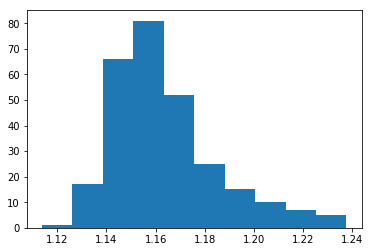

In [7]:
plt.hist(success_times)
plt.show()

In [8]:
print(len(femtimess))
#print(femtimess)
fts = [item for sublist in femtimess for item in sublist]
print(len(fts))

100
564


In [9]:
print(len(discards))

102


In [10]:
fitness_states

[4,
 6,
 0,
 0,
 8,
 6,
 6,
 2,
 1,
 0,
 0,
 2,
 6,
 9,
 8,
 0,
 4,
 3,
 1,
 0,
 0,
 0,
 9,
 4,
 0,
 7,
 9,
 0,
 7,
 0,
 6,
 9,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 8,
 1,
 0,
 0,
 5,
 4,
 0,
 1,
 0,
 6,
 7,
 0,
 1,
 5,
 0,
 0,
 0,
 5,
 0,
 7,
 0,
 4,
 0,
 4,
 9,
 6,
 0,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 9,
 3,
 2,
 5,
 0,
 8,
 0,
 6,
 0,
 0,
 0,
 9,
 2,
 0,
 5,
 2,
 6,
 0,
 8,
 3,
 0,
 0,
 6]